# Cars' data analysis

In this dataset I have information about 10 cars driving on October 8, 2016. I'm going to get as many insights as possible from this data and generate ideas about the ways to sell this data and get profit.

A very important point first. October 8, 2016 is Saturday, which is a weekend in United Arab Emirates (cars coordinates are in this country), so this influences the people activity: some could work, some could entertain themselves, some could buy products for the week and so on.

Also some additional information:
As far as I know speed limit in United Arab Emirates is up to 120 km/h on main roads and 140 km/h on E11. Many drivers maintain higher speed between the speed cameras. So drivers with speeds exceeding the limits should be considered risky.

My analysis goes through the following steps:

- data preparation (dropping unnecessary data and duplicate rows as well as transforming variables);
- looking at basic general information about the cars;
- main analysis of the data and drawing driving pathes of the cars;
- conclusions;

1. [Data preparation](#datprep)
2. [Basic information](#basic)
3. [Car data analysis](#cars)

    3.1 [Car 1](#car1)

    3.2 [Car 2](#car2)

    3.3 [Car 3](#car3)

    3.4 [Car 4](#car4)

    3.5 [Car 5](#car5)

    3.6 [Car 6](#car6)

    3.7 [Car 7](#car7)

    3.8 [Car 8](#car8)

    3.9 [Car 9](#car9)

    3.10 [Car 10](#car10)
    
4. [Data usage](#concl)

In [1]:
#Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import folium
from folium import plugins
import datetime
from datetime import datetime

## <a name='datprep'>Data preparation</a>

In [2]:
#Reading the data.
data = pd.read_excel('/devices_data.xlsx', encoding='utf-8')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64094 entries, 0 to 64093
Data columns (total 21 columns):
DeviceNumber       64094 non-null object
TimeUtc            64094 non-null datetime64[ns]
Version            64094 non-null int64
Mileage            64094 non-null int64
Longitude          64094 non-null float64
Latitude           64094 non-null float64
Speed              64094 non-null int64
EngineRPM          64094 non-null int64
LockTrunk          64094 non-null int64
LockHood           64094 non-null int64
LockDriver         64094 non-null int64
LockTPassenger     64094 non-null int64
LockLeftRear       64094 non-null int64
LockRightRear      64094 non-null object
LastSync           64094 non-null datetime64[ns]
LastNumber         64094 non-null int64
EngineOn           64094 non-null int64
Temperature        64094 non-null int64
FuelLevel          64094 non-null int64
AlarmOn            64094 non-null int64
SatellitesCount    64094 non-null int64
dtypes: datetime64[ns](2), 

No missing values, which is convenient. Two columns have data in datetime format, other columns (except DeviceNumber) are numerical. Also LockRightRear has type 'object', which is strange, I'll look into it.

In [4]:
data.head()

,DeviceNumber,TimeUtc,Version,Mileage,Longitude,Latitude,Speed,EngineRPM,LockTrunk,LockHood,...,LockTPassenger,LockLeftRear,LockRightRear,LastSync,LastNumber,EngineOn,Temperature,FuelLevel,AlarmOn,SatellitesCount
0,device_1,2016-10-08 00:00:00,87,639000,53.726430,23.126805,0,0,0,0,...,0,0,00:00:00,2016-10-08 00:00:00,13,0,38,0,0,9
1,device_2,2016-10-08 00:00:06,87,55341000,56.188661,25.518500,0,0,0,0,...,0,0,00:00:00,2016-10-08 00:00:06,22,0,42,0,0,9
2,device_1,2016-10-08 00:00:09,87,639000,53.726430,23.126805,0,0,0,0,...,0,0,00:00:00,2016-10-08 00:00:09,13,0,38,0,0,9
3,device_3,2016-10-08 00:00:18,87,227000,55.244163,25.205136,0,0,0,0,...,0,0,00:00:00,2016-10-08 00:00:18,21,0,43,0,0,4
4,device_4,2016-10-08 00:00:22,87,354000,55.399996,25.278216,0,0,0,0,...,0,0,00:00:00,2016-10-08 00:00:22,14,0,45,0,0,9


This is how the data looks like. Let's start the analysis.

In [5]:
len(data.FuelLevel.unique()), len(data.AlarmOn.unique())

(1, 1)

FuelLevel and AlarmOn have only one distinct value each, this means that fuel level isn't measured. Alarm is also not measured or isn't activated. So these columns can be dropped.

In [6]:
data.LockRightRear.value_counts()

00:00:00               63937
1900-01-01 00:00:00      157
Name: LockRightRear, dtype: int64

LockRightRear column has two distinct values and they are strange. I suppose that there was a problem with formatting, so '00:00:00' is 0 and the other value is 1. I'll fix it.

In [7]:
data['LockRightRear'] = data['LockRightRear'].apply(lambda x: 0 if str(x) == '00:00:00' else 1)

In [8]:
data.loc[data.Version == 87].DeviceNumber.unique(), data.loc[data.Version == 94].DeviceNumber.unique()

(array(['device_1', 'device_2', 'device_3', 'device_4', 'device_5',
        'device_8', 'device_9', 'device_10'], dtype=object),
 array(['device_6', 'device_7'], dtype=object))

Two cars have one version, the rest have another. I suppose that this is software version. Not much useful information there, so I'll drop it.

In [9]:
data.loc[data.TimeUtc != data.LastSync]

,DeviceNumber,TimeUtc,Version,Mileage,Longitude,Latitude,Speed,EngineRPM,LockTrunk,LockHood,...,LockTPassenger,LockLeftRear,LockRightRear,LastSync,LastNumber,EngineOn,Temperature,FuelLevel,AlarmOn,SatellitesCount
11265,device_8,2016-10-08 08:00:38,87,11000,55.477608,25.349330,0,803,0,0,...,0,0,0,2016-10-08 08:00:35,14,1,43,0,0,7
11280,device_8,2016-10-08 08:00:50,87,11000,55.477608,25.349330,0,0,0,0,...,0,0,0,2016-10-08 08:00:47,15,0,43,0,0,7
11302,device_8,2016-10-08 08:01:18,87,11000,55.477608,25.349330,0,800,0,0,...,0,0,0,2016-10-08 08:01:15,16,1,43,0,0,7
16981,device_8,2016-10-08 10:12:34,87,19000,55.441016,25.341671,0,712,0,0,...,0,0,0,2016-10-08 10:11:40,17,1,47,0,0,10
17012,device_8,2016-10-08 10:13:02,87,19000,55.441016,25.341671,0,0,0,0,...,0,0,0,2016-10-08 10:12:47,18,0,47,0,0,10


There is a column with LastSync time, but it differs from TimeUtc only in 5 rows and the difference isn't high. So this column can also be dropped.

In [10]:
for i in range(1, 11):
    dev = 'device_' + str(i)
    print(dev, data.loc[data.DeviceNumber == str(dev)].LastNumber.unique())

device_1 [13]
device_2 [22]
device_3 [21]
device_4 [14]
device_5 [16]
device_6 [17]
device_7 [25]
device_8 [13 14 15 16 17 18]
device_9 [18]
device_10 [27]


Nine devices have one value of LastNumber and the 8th device has 6 distinct values. I have no idea about what 'LastNumber' is, so I'll drop it.

In [11]:
#Drop columns
data.drop(['FuelLevel', 'AlarmOn', 'LastSync', 'Version', 'LastNumber'], axis=1, inplace=True)

In [12]:
len(data.drop_duplicates(subset=['DeviceNumber', 'TimeUtc'], keep=False)) / len(data)

0.7785596155646395

Almost 23% of all rows are duplicates, this means there are many lines with the same time for a device. I decided to completely drop these columns: data granularity is high, so this won't have a serious impact. And if some data looks strange after dropping the rows - I can get them back.

In [13]:
data.drop_duplicates(subset=['DeviceNumber', 'TimeUtc'], keep=False, inplace=True)

In [14]:
data.loc[data.DeviceNumber == 'device_1']['Mileage'].max() - data.loc[data.DeviceNumber == 'device_1']['Mileage'].min()

314000

In [15]:
data.Speed.max()

208

So max speed is 208, I think this is km/hour (if this is miles/hour, then the speed is ~344 km/hour, which is too high for normal car).
And day distance for the first car is 314000. I think these are meters, so I'll convert them to kilometers.

In [16]:
data['Mileage'] = data['Mileage'] / 1000

In [17]:
#All the data is in one day, so I'll leave just the time.
data['TimeUtc'] = data['TimeUtc'].dt.time

In [18]:
data.head()

,DeviceNumber,TimeUtc,Mileage,Longitude,Latitude,Speed,EngineRPM,LockTrunk,LockHood,LockDriver,LockTPassenger,LockLeftRear,LockRightRear,EngineOn,Temperature,SatellitesCount
0,device_1,00:00:00,639.0,53.726430,23.126805,0,0,0,0,0,0,0,0,0,38,9
1,device_2,00:00:06,55341.0,56.188661,25.518500,0,0,0,0,0,0,0,0,0,42,9
2,device_1,00:00:09,639.0,53.726430,23.126805,0,0,0,0,0,0,0,0,0,38,9
3,device_3,00:00:18,227.0,55.244163,25.205136,0,0,0,0,0,0,0,0,0,43,4
4,device_4,00:00:22,354.0,55.399996,25.278216,0,0,0,0,0,0,0,0,0,45,9


This is how the data looks like after the changes.

## <a name='basic'>Basic information</a>

At first I wasn't sure how to interpret information in columns LockTrunk, LockHood, LockDriver, LockTPassenger, LockLeftRear, LockRightRear. They have a lot of zero values and only several percent of values '1'. Then I found out that values '1' appeared in columns LockTrunk, LockHood and LockRightRear only when speed was zero. And '1' appeared in other columns at zero or low speeds. I colclude that '1' means that trunk, hood or a door was opened.

If the hood is opened, this could mean that there are some problems with the car or that it had a planned check-up.

If the trunk is opened, I assume that some baggage was put into it or was taken from it.

Opened driver door means that the driver enteres or leaves the car.

Opened passenger or rear door means that there was a passenger on the relevant seat. Well, it could also mean that something was put onto or taken from the relevant seat, but I have no way to distinguish. Also one should notice that if only one back door was opened, it doesn't mean that there is only one passenger on the back seat.

Now let's get some basic information.

In [19]:
for i in range (1,11):
    device = 'device_' + str(i)
    data_device = data.loc[data.DeviceNumber == str(device)]
    distance = data_device['Mileage'].max() - data_device['Mileage'].min()
    trunk = '' if data_device['LockTrunk'].max() == 0 else 'Opened trunk. '
    hood = '' if data_device['LockHood'].max() == 0 else 'Opened hood. '
    tpassenger = '' if data_device['LockTPassenger'].max() == 0 else 'Has tpassenger. '
    rear = '' if data_device['LockLeftRear'].max() == 0 or data_device['LockRightRear'].max() == 0 else 'Has back passenger.'
    print(device[7:], 'Mileage:', data_device['Mileage'].min(), '+', distance, 'or', 
        '{:.2f}%.'.format((distance / data_device['Mileage'].min()) * 100),
          trunk + hood + tpassenger + rear)

1 Mileage: 639.0 + 314.0 or 49.14%. Opened trunk. Has tpassenger. Has back passenger.
2 Mileage: 55341.0 + 345.0 or 0.62%. Has tpassenger. Has back passenger.
3 Mileage: 227.0 + 29.0 or 12.78%. Has tpassenger. 
4 Mileage: 354.0 + 44.0 or 12.43%. Has tpassenger. Has back passenger.
5 Mileage: 223.0 + 0.0 or 0.00%. Opened trunk. Opened hood. Has tpassenger. 
6 Mileage: 243.0 + 303.0 or 124.69%. Opened trunk. Has tpassenger. Has back passenger.
7 Mileage: 18.0 + 278.0 or 1544.44%. Opened trunk. Opened hood. Has tpassenger. Has back passenger.
8 Mileage: 11.0 + 437.0 or 3972.73%. Opened trunk. Opened hood. Has tpassenger. Has back passenger.
9 Mileage: 326.0 + 13.0 or 3.99%. Opened trunk. Has tpassenger. Has back passenger.
10 Mileage: 151.0 + 131.0 or 86.75%. Opened trunk. Has tpassenger. Has back passenger.


Seven cars used trunk, 3 cars opened hood, all had a passeanger at the front seat, 8 had rear passengers.

One car (5) didn't drive at all. Cars 7 and 8 are quite new - mileage is really low. Car 9 drove a little, cars 3 and 4 drove a bit more. Cars 2 and 8 drove quite far. And car 2 has the highest starting mileage.

This is a basic analysis and the conclusions may be changed.

In [20]:
data1 = data.loc[data.DeviceNumber == 'device_1']
data1['acceleration1'] = data1.Speed.shift(-1) - data1.Speed
data1.loc[data1.acceleration1 > 40].acceleration1

D:\Programs\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


5999     66.0
6070     99.0
16905    46.0
17002    60.0
17007    68.0
17058    49.0
17167    58.0
21250    41.0
27622    46.0
28832    52.0
29116    65.0
45330    42.0
Name: acceleration1, dtype: float64

I wanted to analyse acceleration of cars to determine drivers who are prone to abrupt changes is speed, which could cause incidents. But there are a lot of peaks in the data - such high acceleration isn't physically possible. Cleaning or smoothing the data is complicated, so I'll just analyse the speeds.

In [21]:
#The function to plot a column for each device on a separate graph.
def plot_column(column):
    fig, axes = plt.subplots(nrows=5, ncols=2)
    #This sets axes based on device number.
    for i in range(1,11):
        dev = 'device_' + str(i)
        if i in (1,2):
            data.loc[data.DeviceNumber == str(dev)].plot(
                x='TimeUtc', y=column, figsize=(15, 24), ax=axes[0,i-1]); axes[0,i-1].set_title(str(dev));
        elif i in (3,4):
            data.loc[data.DeviceNumber == str(dev)].plot(
                x='TimeUtc', y=column, figsize=(15, 24), ax=axes[1,i-3]); axes[1,i-3].set_title(str(dev));
        elif i in (5,6):
            data.loc[data.DeviceNumber == str(dev)].plot(
                x='TimeUtc', y=column, figsize=(15, 24), ax=axes[2,i-5]); axes[2,i-5].set_title(str(dev));
        elif i in (7,8):
            data.loc[data.DeviceNumber == str(dev)].plot(
                x='TimeUtc', y=column, figsize=(15, 24), ax=axes[3,i-7]); axes[3,i-7].set_title(str(dev));
        elif i in (9,10):
            data.loc[data.DeviceNumber == str(dev)].plot(
                x='TimeUtc', y=column, figsize=(15, 24), ax=axes[4,i-9]); axes[4,i-9].set_title(str(dev));

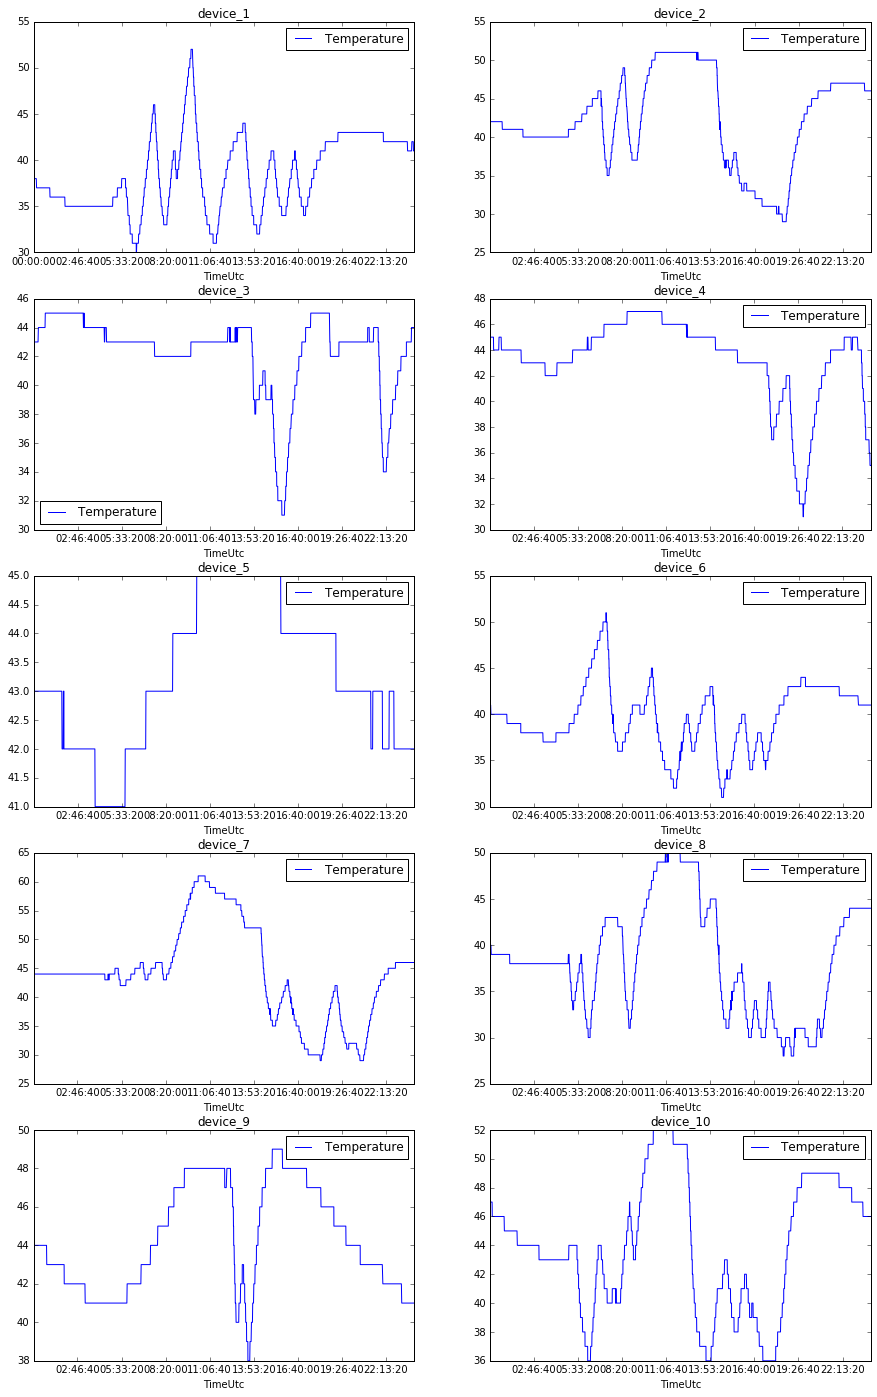

In [22]:
plot_column('Temperature')

The temperature is roughly the same for all cars. In some cases it is lower than 30 or higher than 50. I suppose that it could reach high levels during long stops at sunny places.

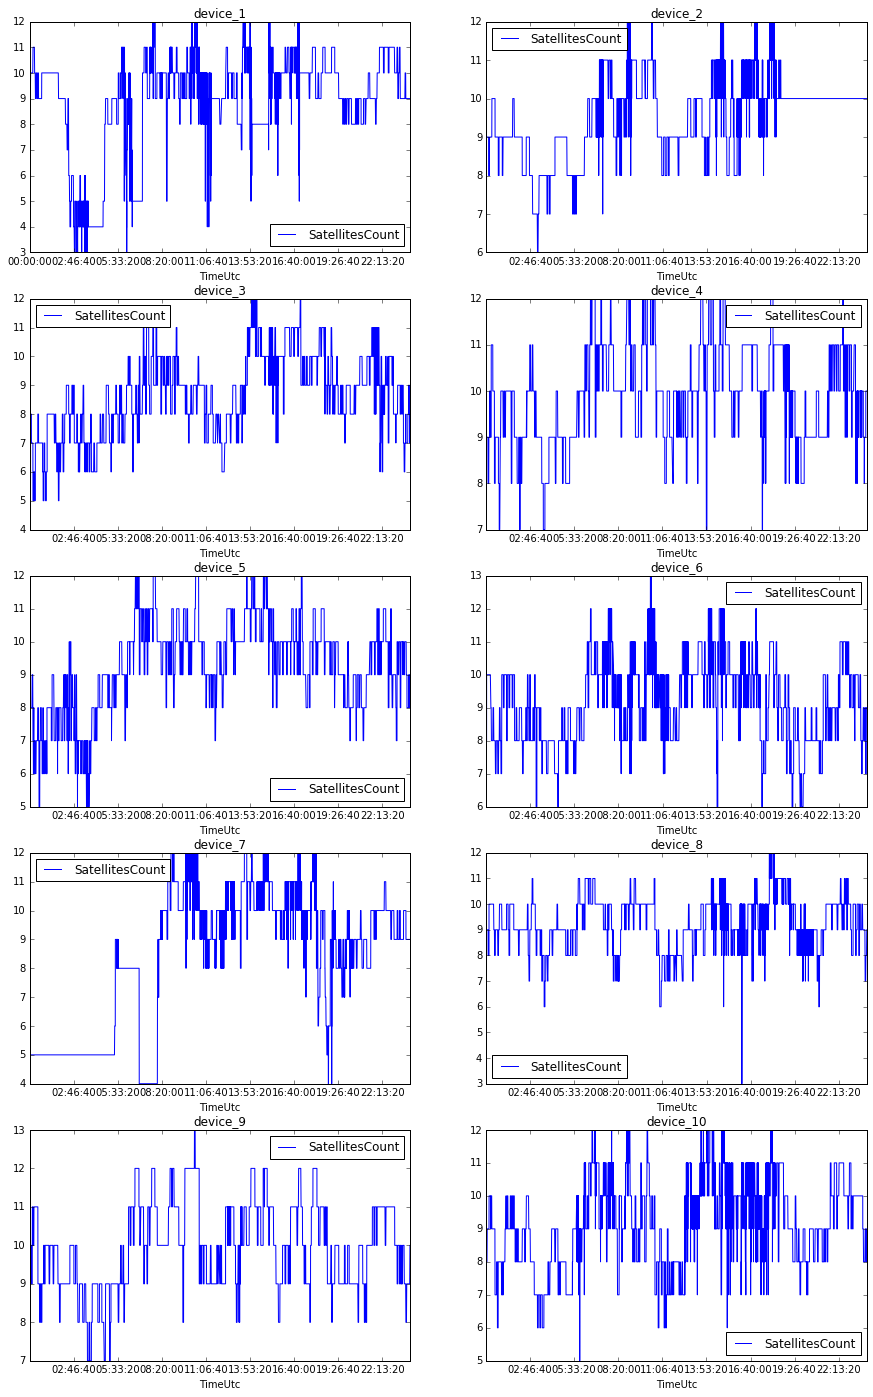

In [23]:
plot_column('SatellitesCount')

This gives me little information. Maybe the number of satellites descreases during long stops, as less presicion is required. And more satellites are necessary when the car is driving.

## <a name='cars'>Car data analysis</a>

Now I analyse the data for each car. I take the following steps:
- Find when a car stops and starts/continues driving. At first I wanted to use column "EngineOn" to determine the "state" of the car, but often cars stayed at the same place for a long time with the engine turned on. So I decided to use Speed. If car's speed is greater than 0, it moves. But car could make short stops due to traffic lights or traffic jams or for some other reasons. So I think that car does a meaningfull stop if it stays motionless for more than 3 minutes;
- Now I can get information about the time at which the car stops or moves;
- I use folium module to plot car's driving path and to shows stops. Markers show the place and the time of the stops as well as the stop's length. Clicking on the map shows a popup with the coordinates;
- Then I plot several graphs: speed and EngineRPM, speed and EngineRPM when the speed is greater than zero (this makes it easier to see the high values);
- At last I show detailed text information about each part of the travel. For each segment I show start and end time. When a car drives, I show mileage and average speed, EngineRPM and temperature. For a motionless car I show whether Trunk, Hood, Driver door, Passenger door, Left rear door and Right rear door were opened.
- Based on these information I analyse the cars.
- The function below performs all the necessary steps, so I just need to call it and to specify the device number.
- I can't analyse some of the stops, as there are no notable places near them. I usually omit these stops from analysis.
- I don't know the gender of the driver, so I'll 'he/she' pronoun.
- As the data covers only one day and the day is weekend, conclusions are made based only on this day. Usual behavious can't be derived, so data shows only how a driver spends one of his weekends. If we need to create a behavioral profile of the driver, data for more days is necessary.

In [24]:
def car_data(device):
    #Use the data only for the current device.
    data_device = data.loc[data.DeviceNumber == str(device)]
    #Starting coordinates, coordinates of all stops will be added to this list.
    loc = [(data_device.iloc[0,3], data_device.iloc[0,4])]
    #Time of stops.
    stop_time = [data_device.iloc[0,1]]
    #Length of stops.
    stop_length = []
    #Time of the last stop. Mainly to check that the length of the stop is greater than 3 minutes.
    last_stop = str(data_device.iloc[0,1])
    #Time of leaving the stops.
    move_time = []
    #I go through each row to determine whether the car stops or starts moving (speed becomes 0 or becomes > 0 respectively).
    #If the car moves for the first time, I write first moving time and the length of the initial stops.
    #Then if a car stops and the length of the stop is > 180 seconds, I add information about the coordinates and the time.
    for i in range(1, len(data_device)):    
        if data_device.iloc[i,5] > 0 and data_device.iloc[i-1,5] == 0:
            if last_stop == str(data_device.iloc[0,1]):
                stop_length.append(data_device.iloc[i,1])
                move_time.append(data_device.iloc[i,1])
            else:
                if (datetime.strptime(str(data_device.iloc[i,1]), "%H:%M:%S") \
                    - datetime.strptime(str(last_stop), "%H:%M:%S")).seconds < 180:
                    pass
                else:
                    stop_length.append(datetime.strptime(str(data_device.iloc[i,1]), "%H:%M:%S") \
                    - datetime.strptime(str(last_stop), "%H:%M:%S"))
                    loc.append(loc_temp)
                    stop_time.append(stop_time_temp)
                    move_time.append(data_device.iloc[i,1])
        if data_device.iloc[i,5] == 0 and data_device.iloc[i-1,5] > 0:
            last_stop = data_device.iloc[i,1]
            loc_temp = (data_device.iloc[i,3], data_device.iloc[i,4])
            stop_time_temp = data_device.iloc[i,1]
    
    #Adding information about the final stop.
    loc.append(loc_temp)
    stop_time.append(stop_time_temp)
    stop_length.append('the rest of the day')
    
    #Writing information about distinct latitudes and longitudes for plotting.
    lat_device = list(data_device['Latitude'])
    lon_device = list(data_device['Longitude'])
    lat = [lat_device[0]]
    lon = [lon_device[0]]
    for i in range(1, len(lat_device)):
        if lat_device[i] != lat_device[i-1] or lon_device[i] != lon_device[i-1]:
            lat.append(lat_device[i])
            lon.append(lon_device[i])    
    
    #Plotting the car path on the map with markers for stops. First line centers map on the mean coordinates.
    cars_map = folium.Map(location=[np.mean(lat), np.mean(lon)], zoom_start=10)
    marker_cluster = folium.MarkerCluster().add_to(cars_map)
    #Adding markers for each stop with information about the stop.
    for i in range(len(loc)):
        folium.Marker([loc[i][1], loc[i][0]], popup="Stopped at {0} for {1}".format(stop_time[i],
                                                                                    stop_length[i])).add_to(marker_cluster)
    #Plotting car path.
    folium.PolyLine(zip(lat, lon), color="blue", weight=2.5, opacity=1).add_to(cars_map)
    folium.LatLngPopup().add_to(cars_map)
    
    #Plotting graphs for various variables.
    fig, axes = plt.subplots(nrows=2, ncols=2)
    data_device.plot(x='TimeUtc', y='Speed', figsize=(18, 15), ax=axes[0,0]); axes[0,0].set_title('Speed');
    data_device.loc[data_device.Speed > 0].plot(
        x='TimeUtc', y='Speed', figsize=(18, 15), ax=axes[0,1]); axes[0,1].set_title('Non zero Speed');
    data_device.plot(x='TimeUtc', y='EngineRPM', figsize=(18, 15), ax=axes[1,0]); axes[1,0].set_title('EngineRPM');
    data_device.loc[data_device.Speed > 0].plot(
        x='TimeUtc', y='EngineRPM', figsize=(18, 15), ax=axes[1,1]); axes[1,1].set_title('EngineRPM at non zero Speed');
    
    #Showing car data.
    #Show mileage at the beginning of the day and driving distance for the day.
    mileage = int(data_device['Mileage'].min())
    distance = int(data_device['Mileage'].max()) - mileage
    print('Mileage at the beginning of the day:', str(mileage) + ' km.', 'Drove today', str(distance) + ' km',
          'or increased mileage by', '{:.2f}%.'.format((distance / mileage) * 100))

    #Information about the car at all parts of the travel. Two main states of the car are driving and staying.
    #What can be opened in a car during a stop.
    actions_list = ['LockTrunk', 'LockHood', 'LockDriver', 'LockTPassenger', 'LockLeftRear', 'LockRightRear']
    objects = ['Trunk', 'Hood', 'Driver door', 'Passenger door', 'Left rear door', 'Right rear door']
    #I need a list of timepoints. Didn't find a better way to do it.
    time_points = [None]*(len(stop_time) + len(move_time))
    time_points[::2] = stop_time
    time_points[1::2] = move_time

    #I go through timepoints. For each part of travel I get starting and ending time and the difference between them.
    #For stops I see whether something was opened in a car(column has at leat one 1). And average temperature.
    #For travels I get travel distance and average values of speed, EngineRPM and temperature.
    #For the final stop I get data separately as it differs from usual stops.
    for i in range(0, len(time_points), 2):
        #Actions - temporal list for i.
        actions = []
        if i < len(time_points) - 1:
            for j in range(len(actions_list)):
                if (data_device.loc[(data_device.TimeUtc > time_points[i])
                                    & (data_device.TimeUtc < time_points[i+1])][actions_list[j]] > 0).any():
                    actions.append(objects[j])
            #If nothing was opened, show "nothing"
            actions = actions if len(actions) > 0 else ['nothing']
            
            print(str(time_points[i]) + ' - ' + str(time_points[i+1]),
                  'Stayed for {0}.'.format((datetime.strptime(str(time_points[i+1]), "%H:%M:%S") \
                    - datetime.strptime(str(time_points[i]), "%H:%M:%S"))),
                 'Average temperature was {0}.'.format(round(data_device.loc[(data_device.TimeUtc > time_points[i])
                & (data_device.TimeUtc < time_points[i+1])]['Temperature'].mean())),
                 'Opened: {0}.'.format(', '.join(actions)))

            #Temporal data for the time interval.
            local_data = data_device.loc[(data_device.TimeUtc > time_points[i+1]) & (data_device.TimeUtc < time_points[i+2])]
            
            #There are cases when there is one strange line with nonzero speed among lines with zero speed. This is to check.
            if len(local_data) < 2:
                pass
            else:
                print(str(time_points[i+1]) + ' - ' + str(time_points[i+2]), 'Drove for {0}.'.format(
                        (datetime.strptime(str(time_points[i+2]), "%H:%M:%S") \
                        - datetime.strptime(str(time_points[i+1]), "%H:%M:%S"))),
                     'Traveled {0} km, with average speed {1}, EngineRPM {2} and temperature {3}.'.format(
                    local_data.Mileage.max()-local_data.Mileage.min(),
                        round(local_data.Speed.mean()),
                        round(local_data.EngineRPM.mean()), round(local_data.Temperature.mean())))
            
        elif i == len(time_points)-1:
            for j in range(len(actions_list)):
                if (data_device.loc[data_device.TimeUtc > time_points[i]][actions_list[j]] > 0).any():
                    actions.append(objects[j])
            actions = actions if len(actions) > 0 else ['nothing']
            print(str(time_points[i]) + ' - ' + 'midnight', 'Stayed till the end of the day.',
                 'Average temperature was {0}.'.format(
                    round(data_device.loc[data_device.TimeUtc > time_points[i]]['Temperature'].mean())),
                 'Opened: {0}.'.format(', '.join(actions)))
    
    return cars_map

### <a name='car1'>Car 1</a>

Mileage at the beginning of the day: 639 km. Drove today 314 km or increased mileage by 49.14%.
00:00:00 - 05:43:34 Stayed for 5:43:34. Average temperature was 36. Opened: Trunk, Driver door, Passenger door, Left rear door, Right rear door.
05:43:34 - 06:28:07 Drove for 0:44:33. Traveled 68.0 km, with average speed 103, EngineRPM 1934 and temperature 33.
06:28:07 - 07:34:43 Stayed for 1:06:36. Average temperature was 38. Opened: Trunk, Driver door, Passenger door, Left rear door.
07:34:43 - 07:38:52 Drove for 0:04:09. Traveled 1.0 km, with average speed 24, EngineRPM 1192 and temperature 46.
07:38:52 - 07:45:12 Stayed for 0:06:20. Average temperature was 44. Opened: Driver door.
07:45:12 - 07:48:42 Drove for 0:03:30. Traveled 2.0 km, with average speed 42, EngineRPM 1573 and temperature 41.
07:48:42 - 08:12:48 Stayed for 0:24:06. Average temperature was 37. Opened: Driver door.
08:12:48 - 08:21:20 Drove for 0:08:32. Traveled 7.0 km, with average speed 57, EngineRPM 1704 and temperature

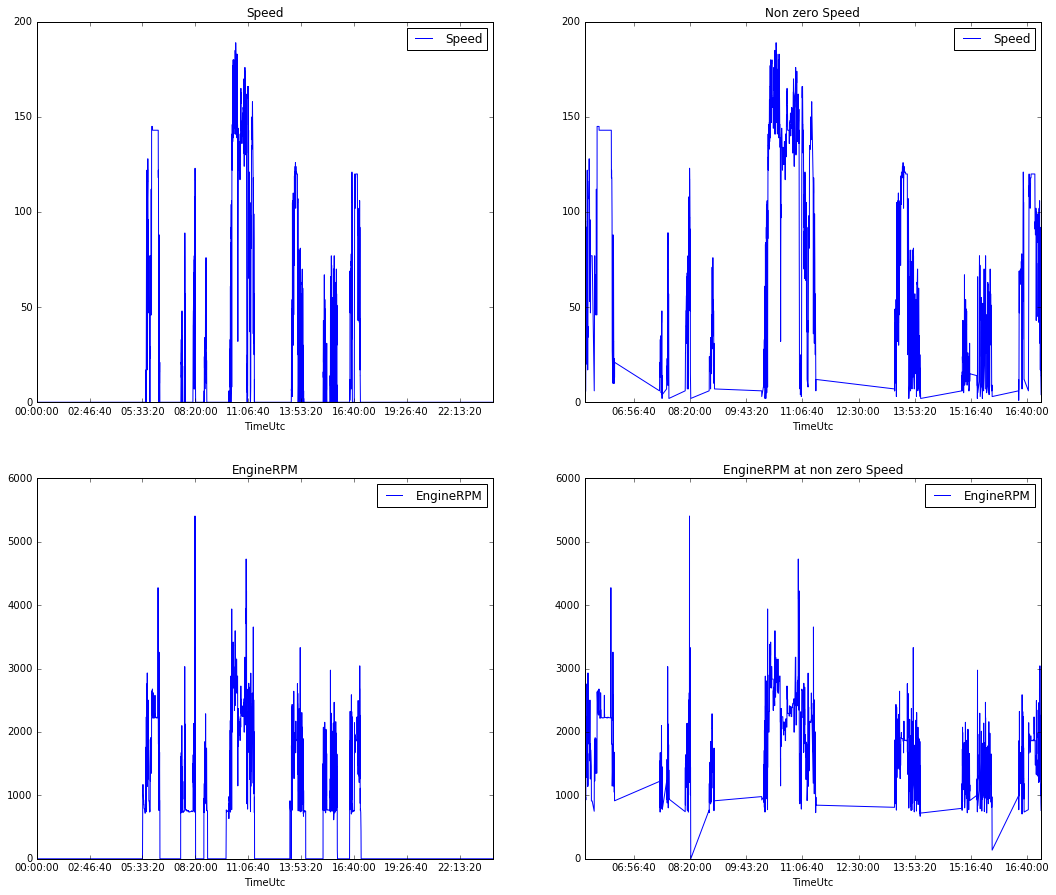

In [25]:
car_data('device_1')

So the car was at home at first. Then the family got into the car (all doors were opened) and some baggage was put into the trunk. They drove for 68 km to a place near a supermarket and KFC. I think that the whole family left the car and went to eat or to the supermarket. After this the driver returned to the car and for some time drove around the area. He/she drove to barber (or to a little cafe), then visited Starbucks. At last car went back to the supermarket to get the family and possible some more things from supermarket. I may guess that during the first stop the products were bought, and then the family went to purchase other items and this was too boring for the driver. Also it is possible that the driver prefers Starbucks, and his family - KFC.

Then they drove to a place in the city and the family left the car here. I suppose that this is their home in the city. After this the driver traveled alone. At first he/she stayed at National Galleria: there are shops, restaurants and other interesting places. Then he/she drove to some place, where he/she didn't even leave the car - maybe someone brought him something? After this he/she stopped near the ministry of foreign affairs (for some business maybe). At last he/she visited the gas station and went home after this at 17 hours.

Average speed was okay, but there were peaks of high speed occasionally and sometimes engime prm was too high. Also he/she drove a lot - almost half of the mileage. This could mean that the car is quite new or is rarely used.

So the driver is a family person. The family buys products on Sunday and eats breakfast in cafe. Then they go to their home in the city and stay their. The driver likes starbucks and deals with some matters in the ministry of foreign affairs. The speed is often risky and engine prm is sometimes pushed to high values.

### <a name='car2'>Car 2</a>

Mileage at the beginning of the day: 55341 km. Drove today 345 km or increased mileage by 0.62%.
00:00:06 - 06:57:06 Stayed for 6:57:00. Average temperature was 41. Opened: Driver door.
06:57:06 - 07:12:32 Drove for 0:15:26. Traveled 20.0 km, with average speed 87, EngineRPM 1874 and temperature 42.
07:12:32 - 07:16:01 Stayed for 0:03:29. Average temperature was 37. Opened: Driver door.
07:16:01 - 07:22:33 Drove for 0:06:32. Traveled 4.0 km, with average speed 39, EngineRPM 1440 and temperature 36.
07:22:33 - 08:25:38 Stayed for 1:03:05. Average temperature was 42. Opened: Driver door.
08:25:38 - 08:31:43 Drove for 0:06:05. Traveled 2.0 km, with average speed 31, EngineRPM 1562 and temperature 48.
08:31:43 - 08:53:53 Stayed for 0:22:10. Average temperature was 42. Opened: Driver door.
08:53:53 - 09:09:54 Drove for 0:16:01. Traveled 20.0 km, with average speed 83, EngineRPM 2153 and temperature 37.
09:09:54 - 13:49:42 Stayed for 4:39:48. Average temperature was 49. Opened: Driver door, 

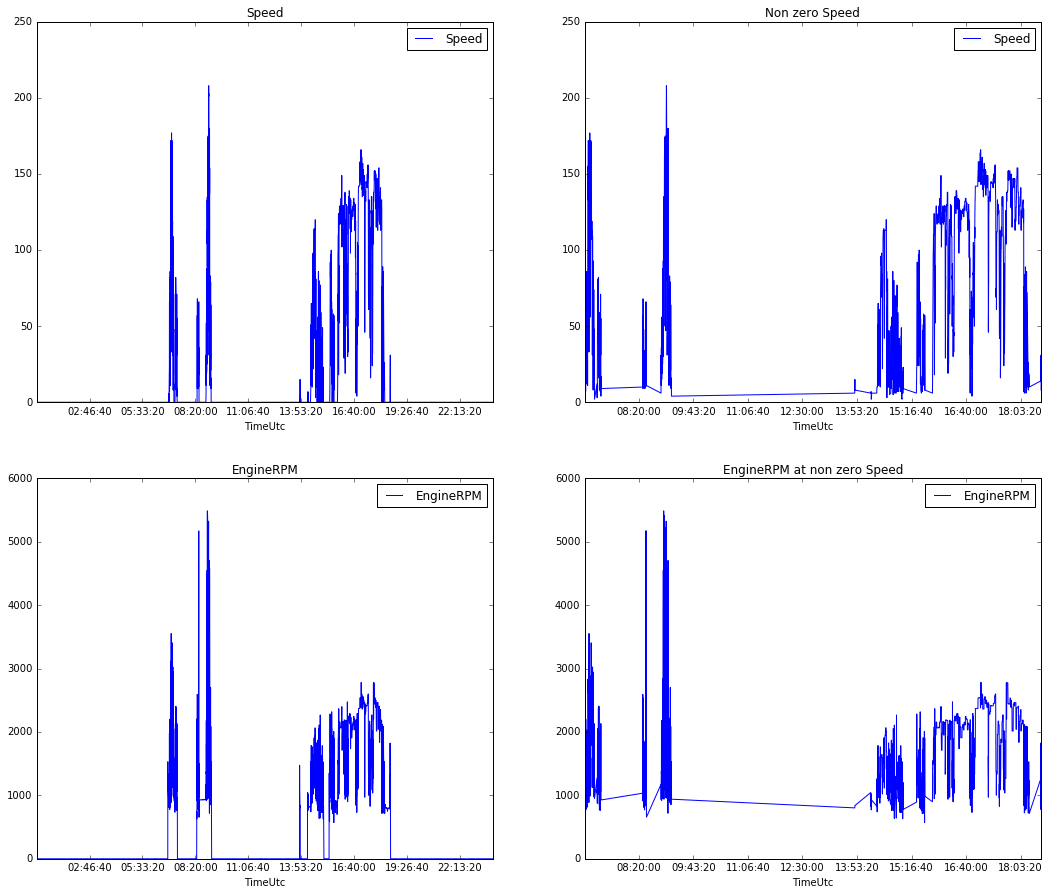

In [26]:
car_data('device_2')

The car was at home at first. Only the driver entered the car. He/she drove to a cafe and stayed there for an hour. Then he/she returned home for several hours and took passengers. I noticed that he/she reparked several times. The car visited a couple of places nearby and then drove to a hotel in Abu Dhabi. Maybe they are going to stay there for a weekend. It is worth noticing that there was no baggage, as trunk wasn't opened.

It seems that the driver likes fast driving and pushing the engine to limits. Also he/she drives a lot - mileage of the car is quite high.

So the driver has a family, he/she likes to have breakfast in cafe and goes to a big city for the weekend with the family.

### <a name='car3'>Car 3</a>

Mileage at the beginning of the day: 227 km. Drove today 29 km or increased mileage by 12.78%.
00:00:18 - 13:46:26 Stayed for 13:46:08. Average temperature was 43. Opened: Driver door, Passenger door.
13:46:26 - 13:50:12 Drove for 0:03:46. Traveled 0.0 km, with average speed 22, EngineRPM 1153 and temperature 42.
13:50:12 - 14:33:40 Stayed for 0:43:28. Average temperature was 40. Opened: Driver door.
14:33:40 - 14:37:04 Drove for 0:03:24. Traveled 1.0 km, with average speed 28, EngineRPM 1245 and temperature 41.
14:37:04 - 15:06:15 Stayed for 0:29:11. Average temperature was 39. Opened: Driver door, Passenger door.
15:06:15 - 15:24:46 Drove for 0:18:31. Traveled 5.0 km, with average speed 29, EngineRPM 1247 and temperature 35.
15:24:46 - 15:32:25 Stayed for 0:07:39. Average temperature was 32. Opened: Driver door.
15:32:25 - 15:42:20 Drove for 0:09:55. Traveled 7.0 km, with average speed 42, EngineRPM 1212 and temperature 32.
15:42:20 - 18:36:10 Stayed for 2:53:50. Average temperature 

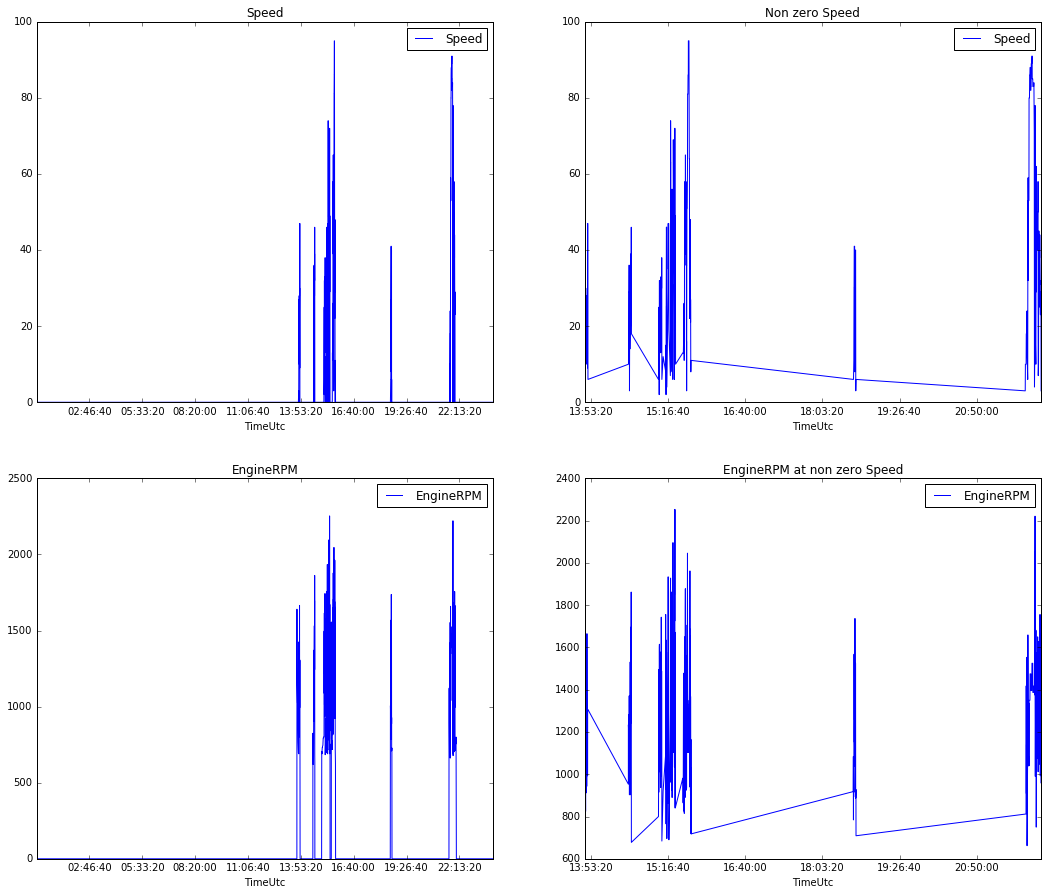

In [27]:
car_data('device_3')

The car was at home until ~ 14 hours. Then the driver and the passenger drove to eat in a nearby place. Strange, but passenger's door wasn't opened here. Maybe the passenger used the driver's door? After eating the car returned home and the passenger left. After this the car drove to Emirates Islamic bank for several minutes - maybe take cash from ATM? The next stop took almost three hours and it was near French international school - maybe learning French? Then one more stop for ~3 hours nearby - a lot of places there - indian high school, catholic church, supermarket, mosque... And then the driver returned home.

Car mileage isn't high, but driving distance also isn't big. Maybe the car was bought several weeks ago? Average speed and Engine RPM are okay.

The driver could be a young person, who likes sleeping late on weekend; he/she eats in a restaurant and visits high school for some courses.

### <a name='car4'>Car 4</a>

Mileage at the beginning of the day: 354 km. Drove today 44 km or increased mileage by 12.43%.
00:00:22 - 17:25:07 Stayed for 17:24:45. Average temperature was 45. Opened: Driver door, Passenger door, Left rear door, Right rear door.
17:25:07 - 17:38:12 Drove for 0:13:05. Traveled 5.0 km, with average speed 35, EngineRPM 1506 and temperature 42.
17:38:12 - 18:50:15 Stayed for 1:12:03. Average temperature was 40. Opened: Driver door, Passenger door.
18:50:15 - 19:41:55 Drove for 0:51:40. Traveled 30.0 km, with average speed 49, EngineRPM 1723 and temperature 35.
19:41:55 - 23:21:28 Stayed for 3:39:33. Average temperature was 41. Opened: Driver door, Passenger door.
23:21:28 - 23:27:42 Drove for 0:06:14. Traveled 4.0 km, with average speed 41, EngineRPM 1465 and temperature 44.
23:27:42 - 23:32:55 Stayed for 0:05:13. Average temperature was 41. Opened: Driver door.
23:32:55 - 23:40:48 Drove for 0:07:53. Traveled 5.0 km, with average speed 52, EngineRPM 1606 and temperature 39.
23:40:48 -

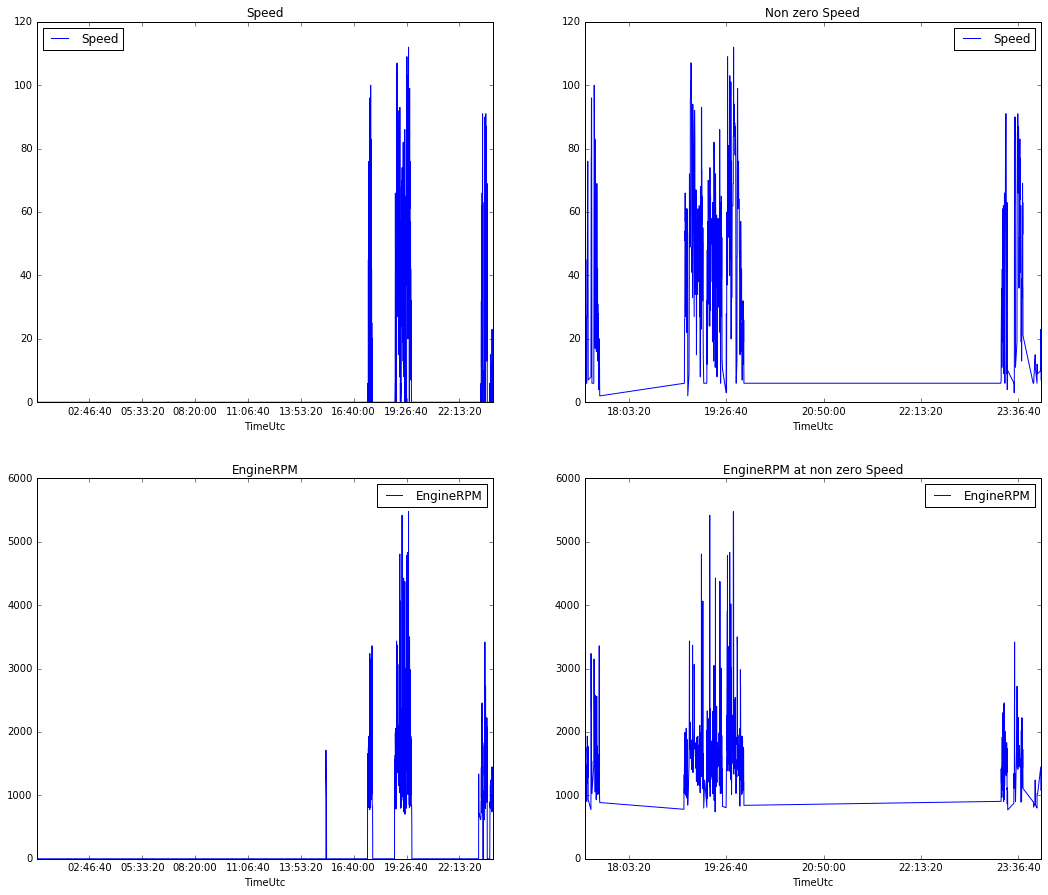

In [28]:
car_data('device_4')

Stayed at home until 17 hours! Took a passenger and drove. Interesting point is that back doors were opened, but other data indicates that there were no one there when the car started driving. So only one passenger.

The car drove to the hospital and stayed there for an hour. Maybe the driver or the passenger had a medical check-up. Or they visited someone. Then they returned home for several hours.

At night the car drove to the pharmacy. After this the car drove to a gas station near supermarket. It seems that the driver isn't going to sleep yet.

Graphs show high speed when the car drove to hospital and back. It seems that the passenger could be relative who urgently needed the medical help.

So the driver has someone, who needs medicine and hospital visits. Also he/she doesn't sleep at late night - maybe it is the stress of the day or it could be a usual situation. And he/she doesn't drive a lot.

### <a name='car5'>Car 5</a>

In [29]:
#Plotting the path of the car.
lat_device = list(data.loc[data.DeviceNumber == 'device_5']['Latitude'])
lon_device = list(data.loc[data.DeviceNumber == 'device_5']['Longitude'])
lat = [lat_device[0]]
lon = [lon_device[0]]
for i in range(1, len(lat_device)):
    if lat_device[i] != lat_device[i-1] or lon_device[i] != lon_device[i-1]:
        lat.append(lat_device[i])
        lon.append(lon_device[i])    

cars_map = folium.Map(location=[np.mean(lat), np.mean(lon)], zoom_start=10)
marker_cluster = folium.MarkerCluster().add_to(cars_map)
folium.PolyLine(zip(lat, lon), color="blue", weight=2.5, opacity=1).add_to(cars_map)
folium.LatLngPopup().add_to(cars_map)
cars_map

This car differs from other cars: it speed is zero for all the day, but it still moves (a little), and it's doors, hood and trunk are opened. The only reason I could think of is that the car is being repaired.

### <a name='car6'>Car 6</a>

Mileage at the beginning of the day: 243 km. Drove today 303 km or increased mileage by 124.69%.
00:00:29 - 07:19:15 Stayed for 7:18:46. Average temperature was 40. Opened: Driver door.
07:19:15 - 08:09:35 Drove for 0:50:20. Traveled 70.0 km, with average speed 101, EngineRPM 1803 and temperature 42.
08:09:35 - 08:18:03 Stayed for 0:08:28. Average temperature was 36. Opened: Driver door.
08:18:03 - 08:32:13 Drove for 0:14:10. Traveled 25.0 km, with average speed 120, EngineRPM 2020 and temperature 37.
08:32:13 - 09:02:06 Stayed for 0:29:53. Average temperature was 39. Opened: Driver door.
09:02:06 - 09:36:08 Drove for 0:34:02. Traveled 22.0 km, with average speed 50, EngineRPM 1422 and temperature 41.
09:36:08 - 10:11:28 Stayed for 0:35:20. Average temperature was 42. Opened: Driver door.
10:11:28 - 11:30:23 Drove for 1:18:55. Traveled 118.0 km, with average speed 101, EngineRPM 1827 and temperature 37.
11:30:23 - 12:25:04 Stayed for 0:54:41. Average temperature was 35. Opened: nothing

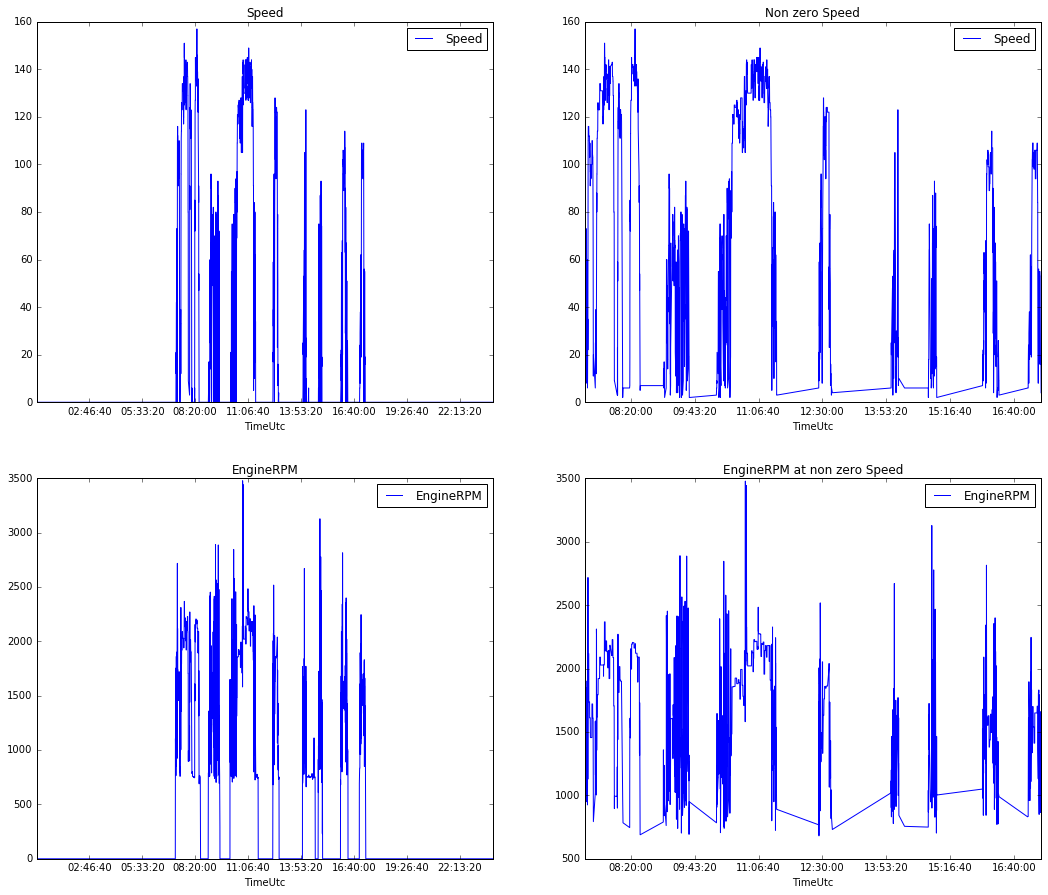

In [30]:
car_data('device_6')

The driver left home alone in the morning. He/she drove to Dubai and during the way stopped at Epco Gas Station. In Dubai he/she stopped near a supermarket and medical center. Then he/she drove to Town Centre Jumeirah - a shopping center. After this he/she drove back and parked near a big shopping center. Later he/she returned home. When the car left, there was a passenger. They arrived to a Tim Hortons - multinational fast food restaurant. Then they (and more passengers) drove back home - maybe they were guests. Some time later the car drove to a place at E11 and left passengers from back seats there. And this was the last destination, as the car returned home at ~ 17 hours.

The car drove at high speeds, but mostly within limits. Maybe sometimes the speed was a bit too high between the speed cameras. It seems that the car is quite new and the driver may use it a lot.

The driver shops a lot and drives many people. A social person.

### <a name='car7'>Car 7</a>

Mileage at the beginning of the day: 18 km. Drove today 278 km or increased mileage by 1544.44%.
00:00:41 - 05:14:15 Stayed for 5:13:34. Average temperature was 44. Opened: Trunk, Hood, Driver door, Passenger door, Left rear door, Right rear door.
05:14:15 - 05:20:39 Drove for 0:06:24. Traveled 1.0 km, with average speed 7, EngineRPM 992 and temperature 45.
05:20:39 - 05:33:07 Stayed for 0:12:28. Average temperature was 43. Opened: Driver door.
05:33:07 - 05:35:24 Drove for 0:02:17. Traveled 0.0 km, with average speed 8, EngineRPM 1044 and temperature 42.
05:35:24 - 06:52:10 Stayed for 1:16:46. Average temperature was 44. Opened: Trunk, Hood, Driver door, Passenger door, Left rear door, Right rear door.
06:52:10 - 06:55:51 Drove for 0:03:41. Traveled 1.0 km, with average speed 9, EngineRPM 1017 and temperature 46.
06:55:51 - 08:02:29 Stayed for 1:06:38. Average temperature was 45. Opened: Trunk, Hood, Driver door, Passenger door, Left rear door.
08:02:29 - 08:05:32 Drove for 0:03:03. T

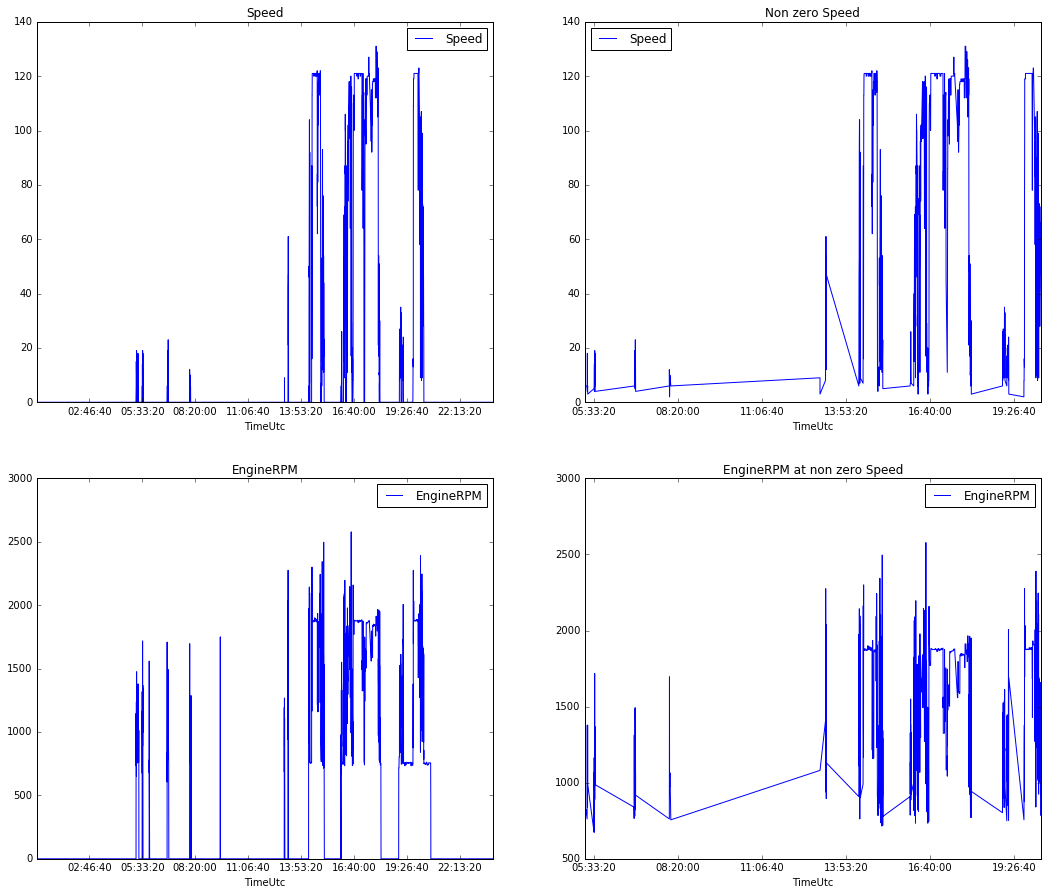

In [31]:
car_data('device_7')

A new car (very low mileage). It seems that there were some problems with the car - the hood was opened in the morning and then the car drove to something like a car shop. Probably there the car was repaired. Then there was a stop at a parking... well, not really. The car was taken to the Dubai - it seems the initial repair wasn't successful. Now the things got better - car became able to move and drove to a gas station.

Then they ate at a restaurant and visited another gas station. Interesting point is that only a driver left the car at a long stop near the restaurant. Maybe the passenger was transported by a car company? Anyway he/she left a passenger at E11 and finished the travel in a place different from the initial. Second home?

The car drove somewhere within the speed limits.

So the new car with some technical problems. Maybe changing it is a good idea? By maybe it is normal for a car to visit the car shop during the first days after the purchase. I can't be sure.

### <a name='car8'>Car 8</a>

Mileage at the beginning of the day: 11 km. Drove today 437 km or increased mileage by 3972.73%.
00:00:44 - 05:04:47 Stayed for 5:04:03. Average temperature was 38. Opened: Driver door.
05:04:47 - 05:07:15 Drove for 0:02:28. Traveled 0.0 km, with average speed 12, EngineRPM 1161 and temperature 36.
05:07:15 - 05:43:40 Stayed for 0:36:25. Average temperature was 36. Opened: Driver door, Passenger door.
05:43:40 - 05:46:54 Drove for 0:03:14. Traveled 0.0 km, with average speed 5, EngineRPM 968 and temperature 39.
05:46:54 - 06:13:29 Stayed for 0:26:35. Average temperature was 34. Opened: Driver door.
06:13:34 - 06:24:51 Stayed for 0:11:17. Average temperature was 31. Opened: Trunk, Driver door, Passenger door, Left rear door, Right rear door.
06:24:51 - 06:27:29 Drove for 0:02:38. Traveled 0.0 km, with average speed 3, EngineRPM 931 and temperature 33.
06:27:29 - 08:26:44 Stayed for 1:59:15. Average temperature was 40. Opened: Trunk, Hood, Driver door, Passenger door, Left rear door, Rig

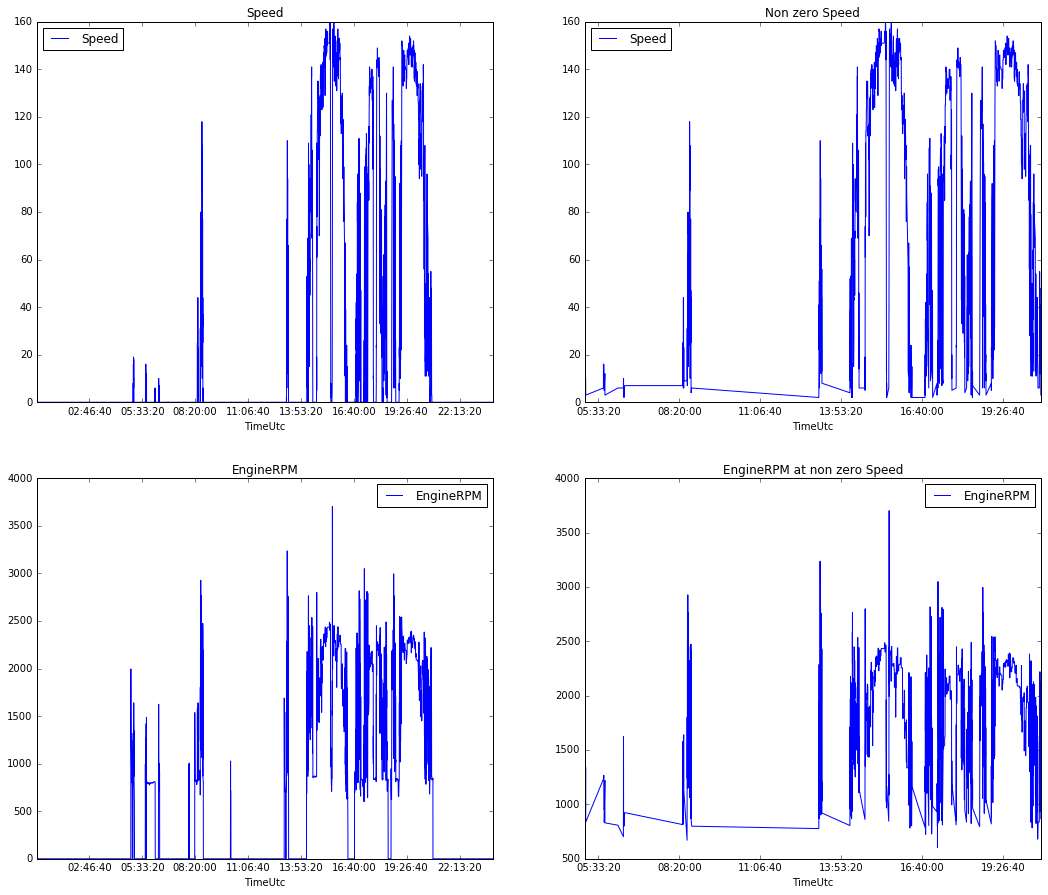

In [32]:
car_data('device_8')

It seems that this is also a new car with some technical problems: in the morning the hood was opened and then nearby car center was visited. Or the car simply was in the car center and it was driven to the owner's place later. Another possibility is that the car was bought in the morning, but not sure - it is quite early.
 
Then the car drove to Abu Dhabi and visited a gas station on the way there. Also a stop was made at two more gas station. 

After this the car drove to some place called Village Center, but nobody left the car. Maybe there was a short meeting with someone? And then the car returned to the first city.

Very high speed. A new car. And several visits to gas stations. Not sure what to conclude. Could this be an electrical car? Or maybe it is simply a new car and that's the reason for it's behavior.

### <a name='car9'>Car 9</a>

Mileage at the beginning of the day: 326 km. Drove today 13 km or increased mileage by 3.99%.
00:00:45 - 12:28:30 Stayed for 12:27:45. Average temperature was 44. Opened: Driver door, Left rear door.
12:28:30 - 12:42:21 Drove for 0:13:51. Traveled 6.0 km, with average speed 39, EngineRPM 1520 and temperature 45.
12:42:21 - 13:11:36 Stayed for 0:29:15. Average temperature was 41. Opened: Trunk, Driver door, Left rear door, Right rear door.
13:11:36 - 13:21:54 Drove for 0:10:18. Traveled 7.0 km, with average speed 59, EngineRPM 1810 and temperature 42.
13:21:54 - midnight Stayed till the end of the day. Average temperature was 45. Opened: Trunk, Driver door, Passenger door, Left rear door, Right rear door.


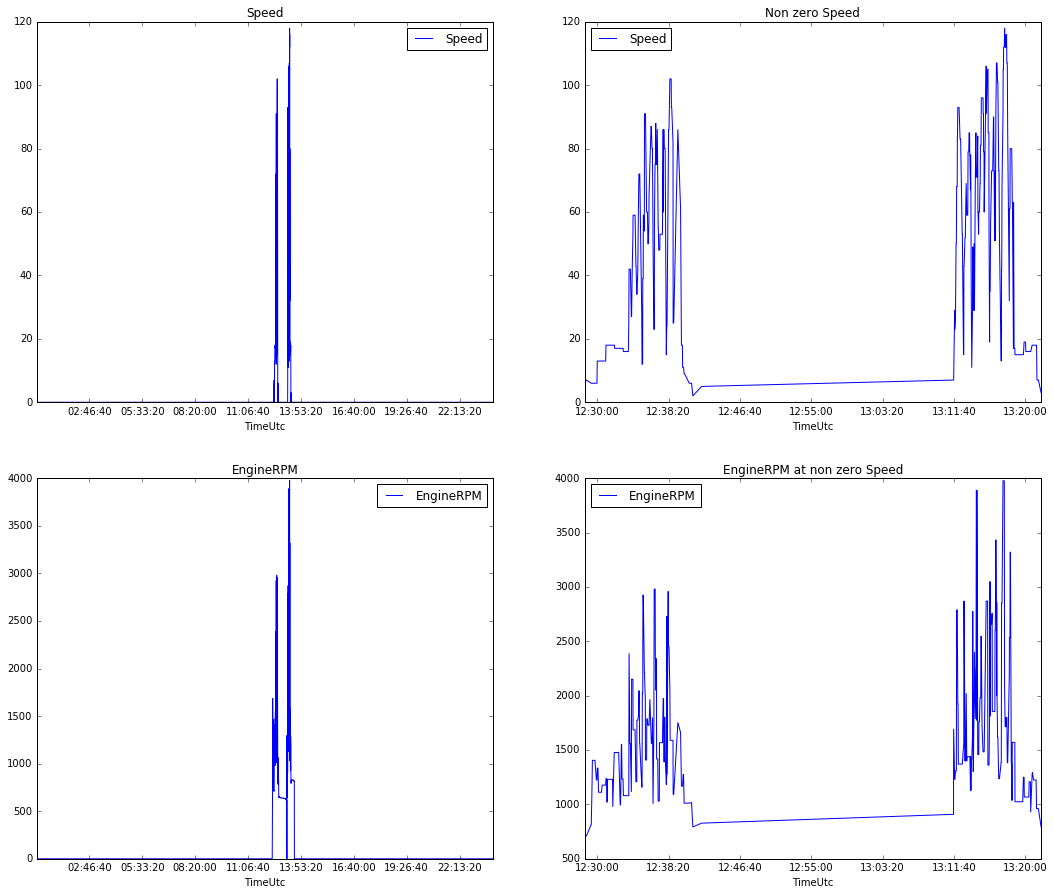

In [33]:
car_data('device_9')

Very little data. A family drove the car at midday. They stayed at some place for half an hour and returned home. The car is quite new and is little used today. It seems that the driver likes to drive fast.

### <a name='car10'>Car 10</a>

Mileage at the beginning of the day: 151 km. Drove today 131 km or increased mileage by 86.75%.
00:00:59 - 05:26:08 Stayed for 5:25:09. Average temperature was 44. Opened: Driver door.
05:26:08 - 05:29:18 Drove for 0:03:10. Traveled 1.0 km, with average speed 26, EngineRPM 1216 and temperature 44.
05:29:18 - 05:43:09 Stayed for 0:13:51. Average temperature was 41. Opened: Driver door, Passenger door, Left rear door.
05:43:09 - 05:49:38 Drove for 0:06:29. Traveled 3.0 km, with average speed 34, EngineRPM 1385 and temperature 39.
05:49:38 - 05:53:31 Stayed for 0:03:53. Average temperature was 38. Opened: Driver door.
05:53:31 - 05:56:34 Drove for 0:03:03. Traveled 1.0 km, with average speed 41, EngineRPM 1501 and temperature 38.
05:56:34 - 06:11:15 Stayed for 0:14:41. Average temperature was 37. Opened: Driver door.
06:11:15 - 06:16:26 Drove for 0:05:11. Traveled 4.0 km, with average speed 49, EngineRPM 1317 and temperature 36.
06:16:26 - 06:51:00 Stayed for 0:34:34. Average temperature 

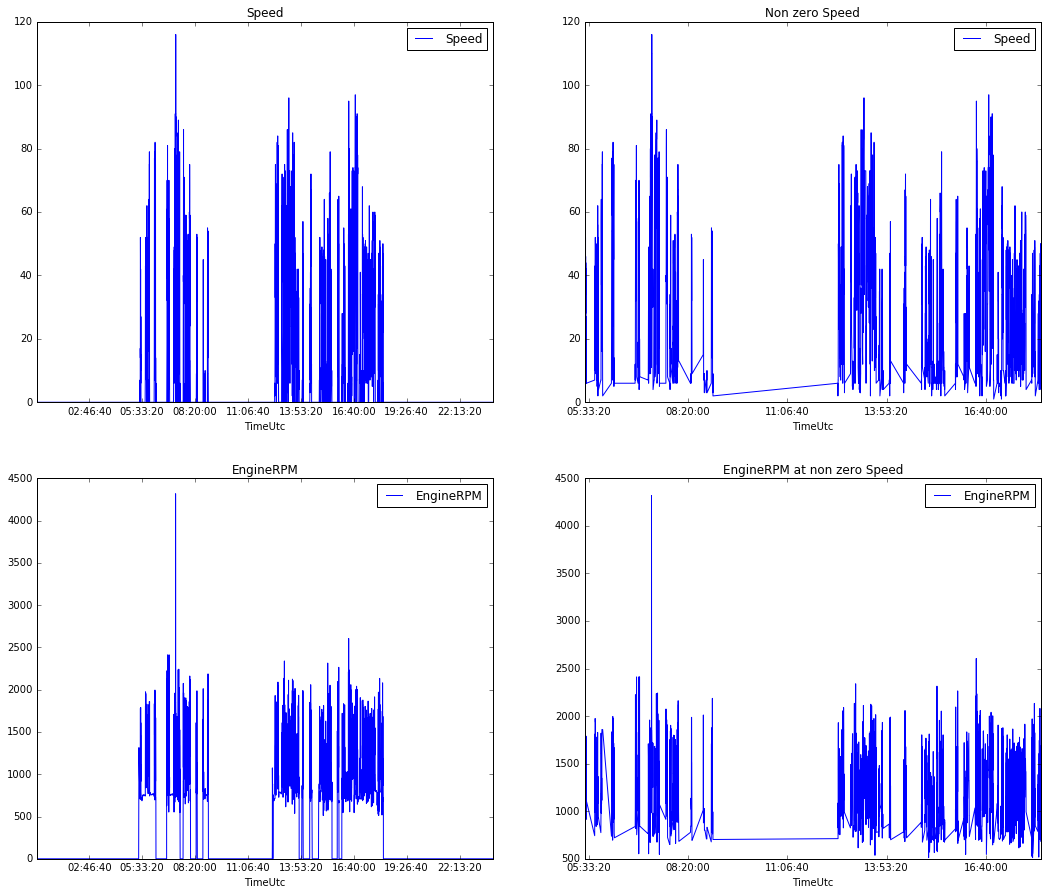

In [34]:
car_data('device_10')

This car drives actively. It drives around a town and makes stops at various places. Most of the time the speed is normal, except one time period with a high speed. The key is in the starting and ending point, which was also visited three times during the day: it is near Fujairah Police Station. So I conclude that this is a police car.

## <a name='concl'>Data usage</a>

Insurance companies use telematic data a lot. Usage-based insurance provides lower costs for drivers and lower risks for insurance companies. Telematic data can uncover frauds (nonaccidental crashes) or find the real reason behind the crashes.

Car companies also can gain profit from telematic data. If the car has high mileage, they can offer check-ups for the driver, for example. They may find problems in the car remotely and offer the repair before something breaks. Or maybe based on the information about how the cars are used, the companies will make modifications in future cars.

One more possibility is combining telematic data with smart houses. For example, if the car arrives at home, the garade doors could open automatically.

Another idea is using telematic data for advertising. If the driver often visits supermarkets, products could be offered. If the driver drives to cafes, cafes may be advertised and so on.